In [187]:
from QL_bounce_calc_v3 import *

import warnings
warnings.filterwarnings("ignore") # Fuck around until I find out
p_norm = np.linspace(0, 30, 20)
ksi = np.linspace(-.999, .999, 30)


In [188]:
# WKBeam results, binned in appropriate dimensions
filename_WKBeam = '/home/devlamin/Documents/WKBeam_related/WKBacca_dev_v1/WKBacca_cases/TCV74302/Output_theta_invertedsign/L1_binned_QL_test2.hdf5'

# Equilibrium filename
filename_Eq = '/home/devlamin/Documents/WKBeam_related/WKBacca_QL/WKBacca_cases/TCV74302/L1_raytracing.txt'

WhatToResolve, FreqGHz, mode, Wfct, Absorption, EnergyFlux, rho, theta, npar, nperp = read_h5file(filename_WKBeam)
psi = rho**2
idata = InputData(filename_Eq)
Eq = TokamakEquilibrium(idata)



 WARNING topfile: assuming psi = 1. at the separatrix. 



In [189]:
omega = phys.AngularFrequency(FreqGHz)
ptR, ptZ, ptBt, ptBR, ptBz, ptB, ptNe, ptTe, P, X, R, L, S = config_quantities(psi, theta, omega, Eq)

In [190]:
Edens = 4 * np.pi / c * 1e6 * Wfct[0, :, :, :, 0]
l = 0
t = 30
harm = 2

In [191]:
def D_RF_nobounce(p_norm, ksi, npar, nperp, Wfct, Te, P, X, R, L, S, harm, eps, plot=False):
        
    # The subfunction, that for a given psi_l and ksi, calculates the 
    # contribution to D_RF for a given momentum grid [i].
    # This is done for all harmonics in n.

    npar_tree = KDTree(npar.reshape(-1, 1))
    d_npar = npar[1] - npar[0] # Assume a constant grid for now
    d_nperp = nperp[1] - nperp[0] # Assume a constant grid for now
    

    # Precalculate the inverse ksi*p_norm grid, with a small offset to avoid division by zero
    inv_kp = 1 / (ksi * p_norm + eps)

    # Calculate the relativistic factor, given the thermal momentum at this location
    p_Te = pTe_from_Te(Te) # Normalised to m_e*c
    Gamma = gamma(p_norm, p_Te)

    # Initialise the integrand
    D_RF_integrand = np.zeros_like(p_norm)


    # resonance_N_par gives a 1D array of the resonant Npar values [i]
    # This whole calculation is done dimensionless now. 

    resonance_N_par = N_par_resonant(inv_kp, p_Te, Gamma, X, harm)

    # We can now query the KDTree to get the indices of the resonant values in Npar.
    # The code below efficiently looks for the index of the value in Npar that is closest to the resonant value.
    # This is done for every point in the grid. If it is not within dNpar/2 of any value in Npar, the index is set to -1.
    # This in fact replaces the integral over Npar, as we now just have a 2D array indicating what value of Npar is resonant, if any.

    dist_N_par, ind_N_par = npar_tree.query(np.expand_dims(resonance_N_par, axis=-1), k =5, distance_upper_bound=d_npar*10) #/2
    res_condition_N_par = np.where(np.isinf(dist_N_par), -1, ind_N_par)
    
    i_res, n_par_res = np.where(res_condition_N_par != -1)
    # The array i_res contains the indices of the resonant values in the p_norm grid for this psi, ksi pair.

    # We can now use the mask to select the resonant values in p_norm and calculate the integrand. 
    # Where there is no Npar value resonant, we can skip the calculation.
    print(i_res, n_par_res)
    for i, m in zip(i_res, n_par_res):

        i_npar = res_condition_N_par[i, m]
        # At this point, we check |E|² to see if at Npar[i_npar] (for this p), the beam is present.
        # And if so, for what value of Nperp.

        #TEST Gaussian prefactor based on the resonance condition
        prefac = np.exp(-dist_N_par[i, m]**2/(2*d_npar**2))
        mask_beam_present = Wfct[i_npar, :] > 0 
        indeces_Nperp_beam_present = np.where(mask_beam_present)[0]        

        if np.any(mask_beam_present):
            # Calculate the polarisation for the cells where the beam is present
            # Now that we've pruned all the data so heavily, finally we can calculate the polarisation for the beam cells.
            for i_nperp in indeces_Nperp_beam_present:
                # Calculate local quantities
                N2 = nperp[i_nperp]**2 + npar[i_npar]**2
                K_angle = np.arctan2(npar[i_npar], nperp[i_nperp])
                pol = polarisation(N2, K_angle, P, R, L, S)

                a_perp = A_perp(nperp[i_nperp], p_norm[i], p_Te, ksi, X)

                #Take the bessel functions...
                #And combine to get polarisation term
                
                Pol_term = .5* (pol[0] * bessel_integrand(harm-1, a_perp) + \
                                pol[1] * bessel_integrand(harm+1, a_perp) )+ \
                                    pol[2] * bessel_integrand(harm, a_perp)
                
                # Now we can calculate the integrand for this point in the grid
                D_RF_integrand[i] += d_nperp * prefac * d_npar* nperp[i_nperp] * Pol_term * Wfct[i_npar, i_nperp]

    return D_RF_integrand


In [192]:
D_rf_lj = D_RF_nobounce(p_norm, ksi[1], npar, nperp, \
                                Edens[t, :,:], ptTe[l, t], \
                                    P[l, t], X[l, t], R[l, t], L[l, t], S[l, t], harm, eps).T

[ 2  2  2  2  2  3  3  3  3  3  4  4  4  4  4  5  5  5  5  5  6  6  6  6
  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10 10 10 11 11 11
 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14 15 15 15 15 15 16 16] [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1]


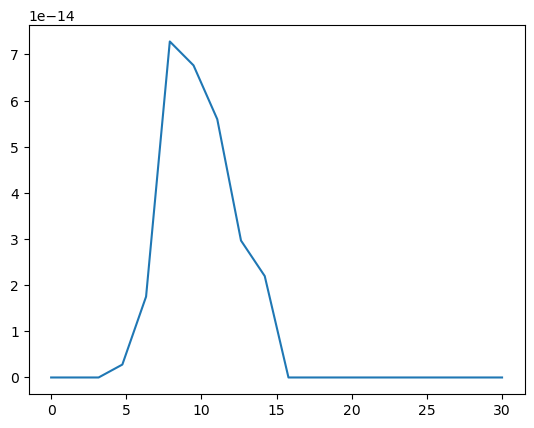

In [193]:
plt.plot(p_norm, D_rf_lj)